# Introduction


This notebook has been prepared as a demo on how to perform aperture photometry in SBC images that contain an elevated dark rate. This problem arises when the detector temperature goes above ~25 ºC. Keep [ISR ACS 2017-04](http://www.stsci.edu/hst/acs/documents/isrs/isr1704.pdf) (Avila 2017) open in a separate browser tab since it will be referred to in this document. The elevated dark primarily affects a large region of the detector just above and to the right of center (see Figure 4 of ISR). 

The following cell loads all the python packages needed for this example. 

In [1]:
from astropy.table import Table
from astropy.io import fits
from astroquery.mast import Observations
from drizzlepac.astrodrizzle import AstroDrizzle as adriz
from matplotlib.colors import LogNorm
from photutils import EllipticalAperture
from photutils import aperture_photometry


import glob
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol


# Data

The necessary data needs to be downloaded and placed in the correct locations.

To run this notebook you will need the RAW dark frames from the calibration program 13961 and FLT and ASN files from visit 11 of program 13655. Place those images in the same directory as this notebook.

The following commands query MAST for the necessery products and then download them.

In [2]:
# Query MAST for the science and dark image data.
science_list = Observations.query_criteria(obs_id='JCMC11*')
Observations.download_products(science_list['obsid'],mrp_only=False,download_dir='./science',
                               productSubGroupDescription=['FLT','ASN'])

darks_list = Observations.query_criteria(proposal_id='13961',obstype='cal')
Observations.download_products(darks_list['obsid'],mrp_only=False,download_dir='./darks',
                               productSubGroupDescription=['RAW'])

# Move the darks to the darks/ directory and the science
# data to the current working directory.
dark_files = glob.glob('darks/mastDownload/HST/*/*fits')
for im in dark_files:
    root = im.split('/')[-1]
    os.rename(im,'darks/'+root)
shutil.rmtree('darks/mastDownload/')

science_files = glob.glob('science/mastDownload/HST/*/*fits')
for im in science_files:
    root = im.split('/')[-1]
    os.rename(im,'./'+root)
shutil.rmtree('science/')

# Overview


What we will try to do here is use dark frames to make a drizzled product that mimics the background in the science product. We will use that drizzled dark product to measure the dark rate to be subtracted from the photometry of the science product.

We are reading in the log file and printing its content. Columns **mdecodt1** and **mdecodt2** contain the temperature at the beginning and end of the exposure respectively.

In [3]:
name = []
starttime = []
filter_name = []
temp1 = []
temp2 = []
avgtemp = []

obslist = glob.glob('jcmc*flt.fits')

# Obtain temperature information from the headers.
# The temperatures are stored in the science extensions
# while we also obtain some observation information
# from the primary header.
for f in obslist:
    with fits.open(f) as hdu:
        hdr0 = hdu[0].header
        hdr1 = hdu[1].header
        
        filt = hdr0['FILTER1']
        t1 = hdr1['MDECODT1']
        t2 = hdr1['MDECODT2']
        
        name.append(f)
        filter_name.append(filt)
        temp1.append(t1)
        temp2.append(t2)
        avgtemp.append((t1+t2)/2)
        starttime.append('{} {}'.format(hdu[0].header['DATE-OBS'], hdu[0].header['TIME-OBS']))

# Create the Astropy Table object and insert the file names, 
# observation start times, and temperatures. Force the column
# order and sort the rows in ascending order of average
# temperature.
tabdata = {'file': name, 'filter1': filter_name, 'mdecodt1': temp1, 
           'mdecodt2': temp2, 'avgtemp': avgtemp, 'start': starttime}
obslog = Table(tabdata, names=('file', 'start', 'filter1', 'mdecodt1', 
                               'mdecodt2', 'avgtemp'))
obslog.sort('avgtemp')
obslog

file,start,filter1,mdecodt1,mdecodt2,avgtemp
str18,str19,str6,float64,float64,float64
jcmc11ctq_flt.fits,2015-04-13 06:09:15,F165LP,16.4715,18.1809,17.3262
jcmc11cwq_flt.fits,2015-04-13 06:27:12,F125LP,18.4251,18.9135,18.6693
jcmc11cxq_flt.fits,2015-04-13 06:35:20,F140LP,19.1577,19.8903,19.524
jcmc11deq_flt.fits,2015-04-13 07:35:02,F150LP,22.5765,23.0649,22.820700000000002
jcmc11dhq_flt.fits,2015-04-13 07:48:02,F150LP,23.0649,23.5533,23.3091
jcmc11dsq_flt.fits,2015-04-13 08:01:30,F140LP,23.5533,24.0417,23.7975
jcmc11dtq_flt.fits,2015-04-13 08:11:43,F125LP,24.0417,24.2859,24.163800000000002
jcmc11e6q_flt.fits,2015-04-13 09:10:52,F165LP,25.7511,26.2395,25.9953


# Creating dark images


The last row in the table above shows one of the F165LP images had an average teperature above 25C and therefore has been affected by elevated dark rate. From the 'start' column, we can see that this is the last image in the visit, which makes sense as the temperature of the SBC steadily increases over time with use. The other F165LP image was taken at the beginning of the visit, therefore it has negligible dark current. However, to accurately account for the dark current in the combined image, we will need to account for the dark current in both input images.

Let's make drizzled products for each filter. We do this by making a list of the ASN files and drizzling those one by one. The drizzle parameters below are the appropriate ones for SBC data. In particular, Steps 1-6 of the drizzling procedure have been turned off since their purpose is to identify and mask cosmic rays. SBC images do not have cosmic rays so you can just proceed straight to the drizzling. We specify that the drizzle products have a plate scale of 0.025"/pixel.

In [4]:
asnlist = glob.glob('*asn.fits')

for asn in asnlist:
    
    exps = fits.getdata(asn)
    first_im = exps['memname'][0]
    output_name = fits.getval(first_im.lower()+'_flt.fits','filter1',ext=0)
    
    adriz(asn,
          output=output_name,
          runfile='',
          context=False,
          build=False,
          preserve=False,
          clean=True,
          static=False,
          skysub=False,
          driz_separate=False,
          median=False,
          blot=False,
          driz_cr=False,
          driz_combine=True,
          final_wcs=True,
          final_scale=0.025
         )

No trailer file created...
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 15:56:04.94 (11/07/2018)

==== Processing Step  Initialization  started at  15:56:04.946 (11/07/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 165.55870940869247  38.04320257728074  
CRPIX : 708.0000105351209  686.0000102072953  
CD1_1 CD1_2  : -5.0808035164716374e-06  -4.733998760982597e-06  
CD2_1 CD2_2  : -4.733998760982597e-06  5.0808035164716374e-06  
NAXIS : 1416  1372
********************************************************************************
*
*  Estimated memory usage:  up to 30 Mb.
*  Output image size:       1416 X 1372 pixels. 
*  Output image file:       ~ 22 Mb. 
*  Cores available:         1
*
********************************************************************************
==== Processing Step  Initialization  finished at  15:56:07.354 (11/07/2018)

==== Processing Step  Static Mask  started at  15:56:07.355 (11/07/2018)
==== Processing S

-Generating simple FITS output: F165LP_drz_sci.fits
Writing out image to disk: F165LP_drz_sci.fits
Writing out image to disk: F165LP_drz_wht.fits
==== Processing Step  Final Drizzle  finished at  15:56:39.245 (11/07/2018)


AstroDrizzle Version 2.2.4 is finished processing at 15:56:39.245 (11/07/2018).


   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          2.2353 sec.
            Static Mask          0.0033 sec.
           Subtract Sky          0.3544 sec.
       Separate Drizzle          0.0003 sec.
          Create Median          0.0000 sec.
                   Blot          0.0047 sec.
                Driz_CR          0.0000 sec.
          Final Drizzle          8.7506 sec.
   ====================          ====================
                  Total          11.3485 sec.
No trailer file saved...
No trailer file created...
AstroDrizzle Version 2.2.4 

Figure 1 of the ISR shows that the dark rate above 25C varies. We therefore can't simply use the dark frames that have the same temperature as your affected science frame. We need to find the dark frame that contains a *dark rate* similar to your affected image. Below we open the two F165LP science frames, one being a high temperature image and the other being a lower-temperature image with negligible dark current. We print out the sum of the pixels inside of a 200x200 box centered at (y, x) = (750, 680), and then do the same for all of the dark frames.

In [5]:
print('For Science Data:\n')
print('jcmc11ctq_flt.fits box sum = {}'.format(np.sum(fits.getdata('jcmc11ctq_flt.fits')[650:850,580:780])))
print('jcmc11e6q_flt.fits bos sum = {}'.format(np.sum(fits.getdata('jcmc11e6q_flt.fits')[650:850,580:780])))

print('\n---------\n')
print('For Dark Frames:\n')
darklist = glob.glob('darks/*fits')
for dark in darklist:
    
    sci = fits.getdata(dark)
    print('{} box sum = {}'.format(dark.split('/')[-1], np.sum(sci[650:850,580:780])))

For Science Data:

jcmc11ctq_flt.fits box sum = 439.7076721191406
jcmc11e6q_flt.fits bos sum = 2438.54150390625

---------

For Dark Frames:

jcrx01ipq_raw.fits box sum = 347
jcrx01ixq_raw.fits box sum = 2196
jcrx01ilq_raw.fits box sum = 348
jcrx01j1q_raw.fits box sum = 3141
jcrx01ioq_raw.fits box sum = 351
jcrx01iqq_raw.fits box sum = 492
jcrx01imq_raw.fits box sum = 299
jcrx01j2q_raw.fits box sum = 3566
jcrx01isq_raw.fits box sum = 777
jcrx01inq_raw.fits box sum = 324
jcrx01iwq_raw.fits box sum = 1904
jcrx01itq_raw.fits box sum = 982
jcrx01ijq_raw.fits box sum = 294
jcrx01iiq_raw.fits box sum = 300
jcrx01ikq_raw.fits box sum = 302
jcrx01iyq_raw.fits box sum = 2445
jcrx01j0q_raw.fits box sum = 2922
jcrx01irq_raw.fits box sum = 644
jcrx01ivq_raw.fits box sum = 1532
jcrx01iuq_raw.fits box sum = 1232


It looks like the two dark frames that come closest to the science frames are **jcrx01iqq** and **jcrx01iyq**. We will use those to make a combined master dark frame. Note that for programs with more exposures, you will need to do this for each input image in the combined mosaic. If *N* images have nearly the same box sum, you can increase the dark current contribution in the master dark we create next by multiplying the corresponding dark image by *N*. 

To do this, we will insert the data of the dark images into copies of the science images. We will do this so that we keep the WCS information in the header to make a drizzled product. We must remember to adjust the exposure time of the copies of the science frames to that of the dark frames so that the drizzled products have the correct count rates.

In [6]:
!cp jcmc11ctq_flt.fits dark1.fits
!cp jcmc11e6q_flt.fits dark2.fits

darkdat1 = fits.getdata('darks/jcrx01iiq_raw.fits').astype(np.float)
with fits.open('dark1.fits',mode='update') as hdu1:
    hdu1[1].data[:,:] = darkdat1
    hdu1[0].header['exptime'] = fits.getval('darks/jcrx01iiq_raw.fits','exptime',ext=0)
    
darkdat2 = fits.getdata('darks/jcrx01iyq_raw.fits').astype(np.float)
with fits.open('dark2.fits',mode='update') as hdu2:
    hdu2[1].data[:,:] = darkdat2
    hdu2[0].header['exptime'] = fits.getval('darks/jcrx01iyq_raw.fits','exptime',ext=0)

We can now make the drizzled dark frame using the two individual dark frames we just made as inputs. The drizzle parameters are the same as the ones used to make the science drizzled products.

In [7]:
adriz(['dark1.fits','dark2.fits'],
        output='masterdark',
        runfile='',
        context=False,
        build=False,
        preserve=False,
        clean=True,
        static=False,
        skysub=False,
        driz_separate=False,
        median=False,
        blot=False,
        driz_cr=False,
        driz_combine=True,
        final_wcs=True,
        final_scale=0.025
       )

No trailer file created...
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 15:56:53.927 (11/07/2018)

==== Processing Step  Initialization  started at  15:56:53.928 (11/07/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 165.5587124860178  38.04320516618952  
CRPIX : 707.5000105276703  686.0000102072953  
CD1_1 CD1_2  : -5.0808035164716374e-06  -4.733998760982597e-06  
CD2_1 CD2_2  : -4.733998760982597e-06  5.0808035164716374e-06  
NAXIS : 1415  1372
********************************************************************************
*
*  Estimated memory usage:  up to 30 Mb.
*  Output image size:       1415 X 1372 pixels. 
*  Output image file:       ~ 22 Mb. 
*  Cores available:         1
*
********************************************************************************
==== Processing Step  Initialization  finished at  15:56:56.180 (11/07/2018)

==== Processing Step  Static Mask  started at  15:56:56.181 (11/07/2018)
==== Processing S

We will now display the images to confirm that they show similar elevated dark rates. You might want do display them in DS9 (or any other viewer) outside of this notebook so you can play with the stretch a bit and so you can see bigger versions of the images.

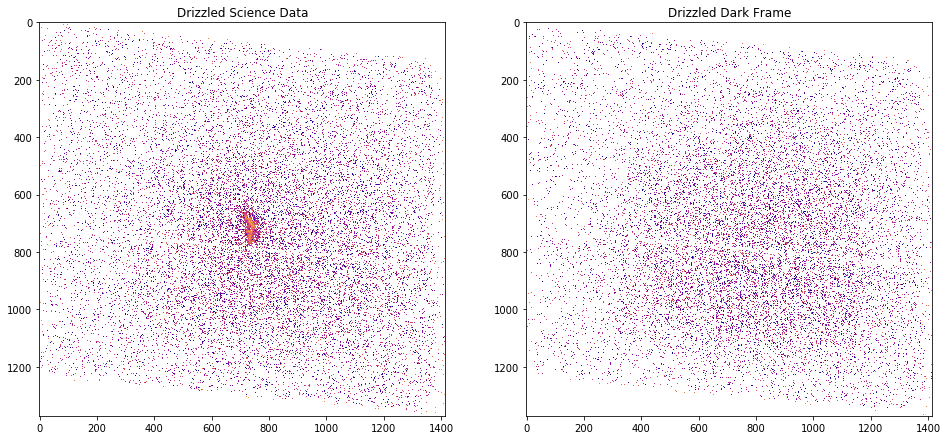

In [8]:
f165lp = fits.getdata('F165LP_drz_sci.fits')
masterdark = fits.getdata('masterdark_drz_sci.fits')

fig,ax = plt.subplots(1,2,figsize=(16,12))

ax[0].set_title('Drizzled Science Data')
ax[1].set_title('Drizzled Dark Frame')

ax[0].imshow(f165lp,norm=LogNorm(),vmin=1e-5,vmax=0.01,interpolation='nearest',cmap='plasma')
ax[1].imshow(masterdark,norm=LogNorm(),vmin=1e-5,vmax=0.01,interpolation='nearest',cmap='plasma')

# Photometry


The images look comparable. We will now proceed to performing some photometric analysis to estimate the dark current in the source.

First we import some tasks from the `photutils` package and then set up two apertures we will use to measure the flux of different regions in the images.  

In [9]:
#This line creates two elliptical apertures.
aper = EllipticalAperture([(735,710),(200,200)],a=70,b=40,theta=0.5*math.pi)

I am overplotting the two apertures in the images so you can see their locations.

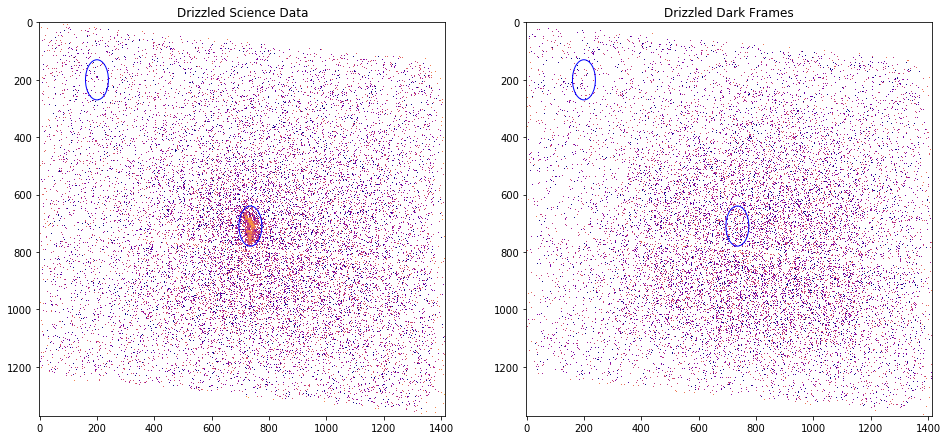

In [10]:
fig,ax = plt.subplots(1,2,figsize=(16,12))

ax[0].set_title('Drizzled Science Data')
ax[1].set_title('Drizzled Dark Frames')

ax[0].imshow(f165lp,norm=LogNorm(),vmin=1e-5,vmax=0.01,interpolation='nearest',cmap='plasma')
ax[1].imshow(masterdark,norm=LogNorm(),vmin=1e-5,vmax=0.01,interpolation='nearest',cmap='plasma')
aper.plot(ax=ax[0],edgecolor='blue')
aper.plot(ax=ax[1],edgecolor='blue')

Finally, we do the photometry using the two apertures on both images. We print out the tables to see the results.

In [11]:
f165lp_phot = aperture_photometry(f165lp, aper)
masterdark_phot = aperture_photometry(masterdark, aper)

sumdiff = f165lp_phot['aperture_sum'] - masterdark_phot['aperture_sum']

print('Science data photometry:\n')
print(f165lp_phot)
print('\n')

print('Dark frame photometry:\n')
print(masterdark_phot)
print('\n')

print('\nDifference of aperture sums (science - dark):\n')
print(sumdiff)

Science data photometry:

 id xcenter ycenter     aperture_sum   
      pix     pix                      
--- ------- ------- -------------------
  1   735.0   710.0   2.865480501122958
  2   200.0   200.0 0.09832536616720805


Dark frame photometry:

 id xcenter ycenter     aperture_sum   
      pix     pix                      
--- ------- ------- -------------------
  1   735.0   710.0 0.32208995630206594
  2   200.0   200.0 0.06845012811569429



Difference of aperture sums (science - dark):

    aperture_sum    
--------------------
   2.543390544820892
0.029875238051513764


The target aperture has 2.86 cts/sec, while the same aperture in the dark frame has 0.322 cts/sec. That means that ~11% of the flux in your source comes from dark current and should be subtracted out, leaving a flux for you source of 2.543 cts/sec. 

# Final thoughts


1. The difference in flux in the second aperture (the one in the lower left portion of the image) shows that there is a small residual background of ~0.02 cts/sec in the science frame. This could be real background from the sky (and not dark current from the detector that you might want to account for properly in your flux and error budget.

2. The dark frame we created does not have the exact same dark count rate as we measured in the science frame. You could try searching for other darks that more closely resemble your science frame. 

3. These problems can be avoided using a few strategies detailed in [ISR ACS 2018-??](http://www.stsci.edu/hst/acs/documents/isrs/) (Avila 2018, in prep.).